# General Imports

In [1]:
import numpy as np
import numpy.typing as npt
import os
import pandas as pd
import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import matplotlib.cm as cm
import seaborn as sns

from functools import singledispatch
import warnings
import logging

# dataset
from sklearn.datasets import fetch_kddcup99
from sklearn.preprocessing import StandardScaler

# pyspark module
from pyspark.rdd import RDD

# src module
#from utils import kddSetup, local_sparkSetup
#from kmeans import compute_centroidDistances, get_clusterId, get_minDistance, cost_function, kMeansParallel_init, kMeansPlusPlus_init, kMeansRandom_init, miniBatchKMeans, naiveKMeans
#from utils import *
#from base import *
#from initialization import *
#from update import *

from src.utils import *
from src.kmeans.base import *
from src.kmeans.initialization import *
from src.kmeans.update import *

# Acess Spark Application

In [2]:
# Setup the spark warnings
warnings.filterwarnings("ignore") 
logging.getLogger('py4j').setLevel(logging.ERROR) 
logging.getLogger('pyspark').setLevel(logging.ERROR) 
log4j_conf_path = "./Settings//log4j.properties"

In [3]:
### DOCKER VERSION
from pyspark.sql import SparkSession

spark = (SparkSession.builder 
        .appName("kMeans") 
        .master("spark://spark-master:7077") 
        .config("spark.driver.memory", "4g") 
        .config("spark.executor.memory", "4g") 
        .config("spark.executor.cores", "2") 
        .config("spark.cores.max", "8") 
        .config("spark.network.timeout", "600s")   
        .config("spark.executor.heartbeatInterval", "60s") 
        .getOrCreate()
        )
sc = spark.sparkContext
sc.setLogLevel("ERROR")

sc.addPyFile("src.zip")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/13 13:00:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load and Test datasets

## Gaussian Mixture

The first dataset we would like to test is a synthetic GaussMixture. To generate it, we sampled kcenters from a 15-dimensional spherical Gaussian distribution with mean at the origin and variance R∈{1,10,100}. We then added points from Gaussian distributions of unit variance around each center. Given the k centers, this is a mixture of k spherical Gaussians with equal weights.

ref{paper kmeans||}

In [4]:
def gauss_mixture(
    n: int=50,  
    k: int=10,
    dim: int=15,                  
    R: int=10
) -> RDD:
    seed = 42
    np.random.seed(seed)
    # Centers generation N(0, R*I)
    centers = np.random.normal(loc=0, scale=np.sqrt(R), size=(k, dim))
    # Point generation N(center, I) for each cluster
    return np.concatenate(
        [center + np.random.randn(n, dim) for center in centers],
        axis=0
    ), centers

In [5]:
"""k = 50
n = 10_000
dim = 15
R = 1
gm_narray, true_centroids = gauss_mixture(n, k, dim, R)
gm_df = pd.DataFrame(gm_narray)
gm_df.tail(2)"""

'k = 50\nn = 10_000\ndim = 15\nR = 1\ngm_narray, true_centroids = gauss_mixture(n, k, dim, R)\ngm_df = pd.DataFrame(gm_narray)\ngm_df.tail(2)'

In [6]:
"""gm_rdd = sc.parallelize([row for row in gm_narray])
gm_rdd"""

'gm_rdd = sc.parallelize([row for row in gm_narray])\ngm_rdd'

In [7]:
"""gm_rdd.count()"""

'gm_rdd.count()'

In [8]:
"""gm_true_cost = compute_cost(gm_rdd, true_centroids)
print(f"{gm_true_cost/1e4:.5f}")
print(gm_true_cost)"""

'gm_true_cost = compute_cost(gm_rdd, true_centroids)\nprint(f"{gm_true_cost/1e4:.5f}")\nprint(gm_true_cost)'

## Reduced KDD

In [9]:
"""kdd_data, kdd_labels, entries_dict = kddSetup(standardize=True)

# get the number of clusters from kdd_labels
k = np.unique(kdd_labels).shape[0]

#parallelize
kdd_rdd = sc.parallelize([row for row in kdd_data])
# kdd_rdd = kdd_rdd.persist()"""

'kdd_data, kdd_labels, entries_dict = kddSetup(standardize=True)\n\n# get the number of clusters from kdd_labels\nk = np.unique(kdd_labels).shape[0]\n\n#parallelize\nkdd_rdd = sc.parallelize([row for row in kdd_data])\n# kdd_rdd = kdd_rdd.persist()'

In [10]:
"""kdd_rdd.count()"""

'kdd_rdd.count()'

In [11]:
"""k = 15
l = k * 10
init_centroids = kMeansParallel_init(kdd_rdd, k, l)
phi_init = cost_function(kdd_rdd, init_centroids)
final_centroids = miniBatchKMeans(kdd_rdd, init_centroids, 20, 0.3)
phi_final = compute_cost(kdd_rdd, final_centroids)"""

'k = 15\nl = k * 10\ninit_centroids = kMeansParallel_init(kdd_rdd, k, l)\nphi_init = cost_function(kdd_rdd, init_centroids)\nfinal_centroids = miniBatchKMeans(kdd_rdd, init_centroids, 20, 0.3)\nphi_final = compute_cost(kdd_rdd, final_centroids)'

In [12]:
"""print(f"{phi_init:.6g}\t{phi_final:.6g}")"""

'print(f"{phi_init:.6g}\t{phi_final:.6g}")'

# kMeans|| Init Tests

## Time / Cost tables

In [13]:
def compute_time_cost(gm_narray, data_rdd, gm_true_cost, k, R, iterations, lk=1, r=5, init_algo="random"):

    # Initialization
    start = time.time()
    
    if init_algo == "random": 
        centroidsRandom = kMeansRandom_init(data_rdd, k)
    elif init_algo == "kmeans++": 
        centroidsRandom = kMeansPlusPlus_init(gm_narray, k)
    elif init_algo == "kmeans||": 
        centroidsRandom = kMeansParallel_init(data_rdd, k, int(lk*k), r)
    else: 
        raise ValueError(f"Wrong initialization algorithm selected: '{init_algo}'")
         
    init_time = time.time() - start
    seed_cost = compute_cost(data_rdd, centroidsRandom)

    # Algo
    start = time.time()
    final_centroids = lloydKMeans(data_rdd, centroidsRandom, iterations)
    final_time = time.time() - start
    final_cost = compute_cost(data_rdd, final_centroids)

    # Store the results in a dictionary
    results = []
    results.append({
        "R": R,
        "init_algo": init_algo,
        "init_time (s)": init_time,
        "up_time (s)": final_time,
        "seed": seed_cost,
        "final": final_cost,
        "true": gm_true_cost
    })
    
    results = pd.DataFrame(results)

    print(results.head()) # DELETE AFTER
    
    return results

In [14]:
def exp10_cost(cost, frac_digits=2):
    """Return exponent 'a' s.t. cost ~10^a, rounded to 'frac_digits' decimals."""
    return float(np.round(np.log10(float(cost)), frac_digits))

### GM dataset creation

We need to create three different dataset for each value of R={1, 10, 100}

In [15]:
# --- control parameters ---
"""k = 50
n = 10_000
dim = 15
R = [1, 10, 100]
r = 5
iterations = 1000"""

# toy parameters for testing
k = 5
n = 100
dim = 15
R = [1, 10, 100]
r = 5
iterations = 10

In [16]:
def create_gm_data(n, k, dim, R, sc):
    """
    Create dataset for different values of R
    """
    gm_narray, true_centroids = gauss_mixture(n, k, dim, R)
    gm_df = pd.DataFrame(gm_narray)
    gm_rdd = sc.parallelize([row for row in gm_narray])
    gm_rdd.count() 
    gm_true_cost = compute_cost(gm_rdd, true_centroids)

    return {
        "narray": gm_narray,
        "df": gm_df,
        "rdd": gm_rdd,
        "true_centroids": true_centroids,
        "true_cost": gm_true_cost,
    }

In [17]:
datasets = {RR: create_gm_data(n, k, dim, RR, sc) for RR in R}

In [18]:
datasets[1]["true_cost"]

15.12295504863026

In [19]:
datasets[10]["true_cost"]

15.197356017266493

In [20]:
datasets[100]["true_cost"]

15.197356017266493

### Random initialization + Lloyd algorithm

In [21]:
results_rand_list = []
for RR in R:
    res = compute_time_cost(
        gm_narray=datasets[RR]["narray"],
        data_rdd=datasets[RR]["rdd"],
        gm_true_cost=datasets[RR]["true_cost"],
        k=k,
        R=RR,
        iterations=iterations,
        lk=1,
        r=r,
        init_algo="random",
    )
    results_rand_list.append(res)

results_rand = pd.concat(results_rand_list, ignore_index=True)

   R init_algo  init_time (s)  up_time (s)       seed      final       true
0  1    random       0.799422     12.18452  26.161987  16.299129  15.122955


    R init_algo  init_time (s)  up_time (s)        seed      final       true
0  10    random       0.983663    24.234593  102.963636  37.809645  15.197356


     R init_algo  init_time (s)  up_time (s)        seed       final  \
0  100    random       0.926295      6.81961  764.433176  294.756284   

        true  
0  15.197356  


In [22]:
results_rand

,R,init_algo,init_time (s),up_time (s),seed,final,true
0,1,random,0.799422,12.184520,26.161987,16.299129,15.122955
1,10,random,0.983663,24.234593,102.963636,37.809645,15.197356
2,100,random,0.926295,6.819610,764.433176,294.756284,15.197356


### kmeans++ initialization + LLoyd algorithm

In [23]:
results_plus_list = []
for RR in R:
    res = compute_time_cost(
        gm_narray=datasets[RR]["narray"],
        data_rdd=datasets[RR]["rdd"],
        gm_true_cost=datasets[RR]["true_cost"],
        k=k,
        R=RR,
        iterations=iterations,
        lk=1,
        r=r,
        init_algo="kmeans++",
    )
    results_plus_list.append(res)

results_plus = pd.concat(results_plus_list, ignore_index=True)

   R init_algo  init_time (s)  up_time (s)       seed      final       true
0  1  kmeans++       0.032853     6.329857  32.042689  14.947757  15.122955


    R init_algo  init_time (s)  up_time (s)       seed      final       true
0  10  kmeans++       0.004005     5.824462  32.012204  15.050722  15.197356
     R init_algo  init_time (s)  up_time (s)       seed      final       true
0  100  kmeans++       0.003951     3.918412  26.993266  15.050722  15.197356


In [24]:
results_plus

,R,init_algo,init_time (s),up_time (s),seed,final,true
0,1,kmeans++,0.032853,6.329857,32.042689,14.947757,15.122955
1,10,kmeans++,0.004005,5.824462,32.012204,15.050722,15.197356
2,100,kmeans++,0.003951,3.918412,26.993266,15.050722,15.197356


### kmeans|| init + Lloyd algorithm

In [25]:
results_par1_list = []
for RR in R:
    res = compute_time_cost(
        gm_narray=datasets[RR]["narray"],
        data_rdd=datasets[RR]["rdd"],
        gm_true_cost=datasets[RR]["true_cost"],
        k=k,
        R=RR,
        iterations=iterations,
        lk=0.5,
        r=r,
        init_algo="kmeans||",
    )
    results_par1_list.append(res)

results_par1 = pd.concat(results_par1_list, ignore_index=True)

   R init_algo  init_time (s)  up_time (s)      seed      final       true
0  1  kmeans||       4.372669     9.035321  25.04243  14.947091  15.122955


    R init_algo  init_time (s)  up_time (s)       seed      final       true
0  10  kmeans||       6.210849     4.651249  25.166306  15.050722  15.197356


     R init_algo  init_time (s)  up_time (s)       seed      final       true
0  100  kmeans||       7.093536     5.520122  21.077598  15.050722  15.197356


In [26]:
results_par1

,R,init_algo,init_time (s),up_time (s),seed,final,true
0,1,kmeans||,4.372669,9.035321,25.042430,14.947091,15.122955
1,10,kmeans||,6.210849,4.651249,25.166306,15.050722,15.197356
2,100,kmeans||,7.093536,5.520122,21.077598,15.050722,15.197356


In [27]:
results_par2_list = []
for RR in R:
    res = compute_time_cost(
        gm_narray=datasets[RR]["narray"],
        data_rdd=datasets[RR]["rdd"],
        gm_true_cost=datasets[RR]["true_cost"],
        k=k,
        R=RR,
        iterations=iterations,
        lk=2,
        r=r,
        init_algo="kmeans||",
    )
    results_par2_list.append(res)

results_par2 = pd.concat(results_par2_list, ignore_index=True)

   R init_algo  init_time (s)  up_time (s)       seed     final       true
0  1  kmeans||        3.42796     6.424335  17.664677  16.25927  15.122955


    R init_algo  init_time (s)  up_time (s)       seed      final       true
0  10  kmeans||       7.497376      7.56107  60.519813  58.699917  15.197356
     R init_algo  init_time (s)  up_time (s)       seed      final       true
0  100  kmeans||       5.991533     3.929929  16.350422  15.050722  15.197356


In [28]:
results_par2

,R,init_algo,init_time (s),up_time (s),seed,final,true
0,1,kmeans||,3.427960,6.424335,17.664677,16.259270,15.122955
1,10,kmeans||,7.497376,7.561070,60.519813,58.699917,15.197356
2,100,kmeans||,5.991533,3.929929,16.350422,15.050722,15.197356


In [29]:
# Rename kmeans|| columns 
results_par1["init_algo"] = "kmeans|| (l*k=0.5)" 
results_par2["init_algo"] = "kmeans|| (l*k=2)" 

# Concatenate all the dataframes 
df_all = pd.concat([results_rand, results_plus, results_par1, results_par2], ignore_index=True) 
#df_all

In [30]:
# Overview of the final results

display(results_rand)
display(results_plus)
print("l*k=0.5")
display(results_par1)
print("l*k=2")
display(results_par2)

,R,init_algo,init_time (s),up_time (s),seed,final,true
0,1,random,0.799422,12.184520,26.161987,16.299129,15.122955
1,10,random,0.983663,24.234593,102.963636,37.809645,15.197356
2,100,random,0.926295,6.819610,764.433176,294.756284,15.197356


,R,init_algo,init_time (s),up_time (s),seed,final,true
0,1,kmeans++,0.032853,6.329857,32.042689,14.947757,15.122955
1,10,kmeans++,0.004005,5.824462,32.012204,15.050722,15.197356
2,100,kmeans++,0.003951,3.918412,26.993266,15.050722,15.197356


l*k=0.5


,R,init_algo,init_time (s),up_time (s),seed,final,true
0,1,kmeans|| (l*k=0.5),4.372669,9.035321,25.042430,14.947091,15.122955
1,10,kmeans|| (l*k=0.5),6.210849,4.651249,25.166306,15.050722,15.197356
2,100,kmeans|| (l*k=0.5),7.093536,5.520122,21.077598,15.050722,15.197356


l*k=2


,R,init_algo,init_time (s),up_time (s),seed,final,true
0,1,kmeans|| (l*k=2),3.427960,6.424335,17.664677,16.259270,15.122955
1,10,kmeans|| (l*k=2),7.497376,7.561070,60.519813,58.699917,15.197356
2,100,kmeans|| (l*k=2),5.991533,3.929929,16.350422,15.050722,15.197356


## Tables results visualization

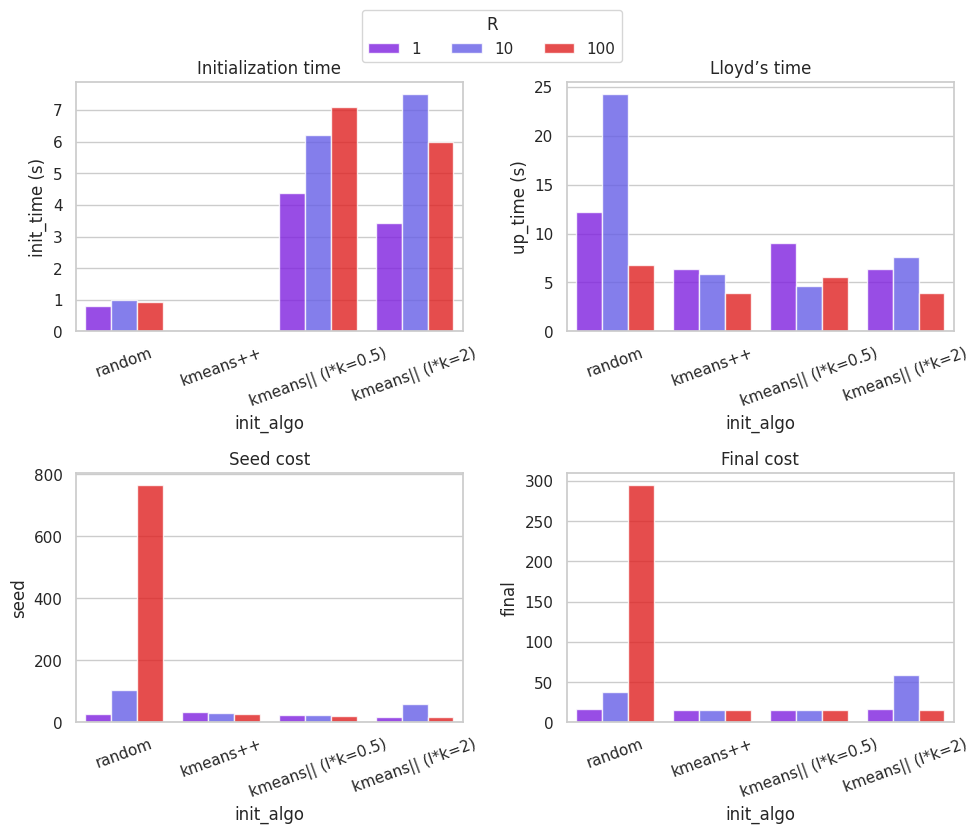

In [31]:
sns.set(style="whitegrid")
matplotlib.rcParams.update({'font.size': 12})

# Define metrics and titles
metrics = ["init_time (s)", "up_time (s)", "seed", "final"]
titles = ["Initialization time", "Lloyd’s time", "Seed cost", "Final cost"]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for ax, metric, title in zip(axs.flat, metrics, titles):
    sns.barplot(
        data=df_all,
        x="init_algo",
        y=metric,
        hue="R",
        palette="rainbow",
        alpha=0.8,
        ax=ax
    )
    ax.set_title(title)
    ax.set_ylabel(metric)
    ax.tick_params(axis="x", rotation=20)
    ax.get_legend().remove() 

# Legend comune in alto
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="upper center",
    ncol=len(labels),
    title="R",
    bbox_to_anchor=(0.5, 1.05)  
)

plt.tight_layout()  
plt.savefig("time_cost_comparison.pdf")
plt.show()

## Old functions

In [32]:
"""#################### RANDOM ####################
data_rdd = gm_rdd
k = 50
iterations = 100
R = 1

######## 1 - Random Init ########
start = time.time()
######## Init ########
centroidsRandom = gm_narray[np.random.choice(gm_narray.shape[0], size=k, replace=False)]
init_time = time.time() - start
seed_cost = compute_cost(data_rdd, centroidsRandom)

algo = "naive"
start = time.time()
######## Algo ########
final_centroids = lloydKMeans(data_rdd, centroidsRandom, iterations)
final_time = time.time() - start
final_cost = compute_cost(data_rdd, final_centroids)"""

'#################### RANDOM ####################\ndata_rdd = gm_rdd\nk = 50\niterations = 100\nR = 1\n\n######## 1 - Random Init ########\nstart = time.time()\n######## Init ########\ncentroidsRandom = gm_narray[np.random.choice(gm_narray.shape[0], size=k, replace=False)]\ninit_time = time.time() - start\nseed_cost = compute_cost(data_rdd, centroidsRandom)\n\nalgo = "naive"\nstart = time.time()\n######## Algo ########\nfinal_centroids = lloydKMeans(data_rdd, centroidsRandom, iterations)\nfinal_time = time.time() - start\nfinal_cost = compute_cost(data_rdd, final_centroids)'

In [33]:
"""results_rand = []
results_rand.append({
    "R": R,
    "algo": "random",
    "init_time (s)": f"{init_time:.3g}",
    "up_time (s)":f"{final_time:.3g}",
    "seed": f"{seed_cost/1e4:.3g}",
    "final": f"{final_cost/1e4:.3g}",
    "true": f"{gm_true_cost/1e4:.3g}"
})

results_rand = pd.DataFrame(results_rand)
results_rand"""

'results_rand = []\nresults_rand.append({\n    "R": R,\n    "algo": "random",\n    "init_time (s)": f"{init_time:.3g}",\n    "up_time (s)":f"{final_time:.3g}",\n    "seed": f"{seed_cost/1e4:.3g}",\n    "final": f"{final_cost/1e4:.3g}",\n    "true": f"{gm_true_cost/1e4:.3g}"\n})\n\nresults_rand = pd.DataFrame(results_rand)\nresults_rand'

In [34]:
"""#################### k-means++ ####################
data_rdd = gm_rdd
k = 50
iterations = 100
R = 1

######## Init ########
start = time.time()
centroidsPlusPlus = kMeansPlusPlus_init(gm_narray, k)
init_time = time.time() - start
seed_cost = compute_cost(data_rdd, centroidsPlusPlus)
######## Algo ########
start = time.time()
final_centroids = lloydKMeans(data_rdd, centroidsPlusPlus, iterations)
final_time = time.time() - start
final_cost = compute_cost(data_rdd, final_centroids)"""

'#################### k-means++ ####################\ndata_rdd = gm_rdd\nk = 50\niterations = 100\nR = 1\n\n######## Init ########\nstart = time.time()\ncentroidsPlusPlus = kMeansPlusPlus_init(gm_narray, k)\ninit_time = time.time() - start\nseed_cost = compute_cost(data_rdd, centroidsPlusPlus)\n######## Algo ########\nstart = time.time()\nfinal_centroids = lloydKMeans(data_rdd, centroidsPlusPlus, iterations)\nfinal_time = time.time() - start\nfinal_cost = compute_cost(data_rdd, final_centroids)'

In [35]:
"""results_plus = []
results_plus.append({
    "R": R,
    "algo": "kmeans++",
    "init_time": f"{init_time:.3g}",
    "up_time":f"{final_time:.3g}",
    "seed": f"{seed_cost/1e4:.3g}",
    "final": f"{final_cost/1e4:.3g}",
    "true": f"{gm_true_cost/1e4:.3g}"
})

results_plus = pd.DataFrame(results_plus)
results_plus"""

'results_plus = []\nresults_plus.append({\n    "R": R,\n    "algo": "kmeans++",\n    "init_time": f"{init_time:.3g}",\n    "up_time":f"{final_time:.3g}",\n    "seed": f"{seed_cost/1e4:.3g}",\n    "final": f"{final_cost/1e4:.3g}",\n    "true": f"{gm_true_cost/1e4:.3g}"\n})\n\nresults_plus = pd.DataFrame(results_plus)\nresults_plus'

In [36]:
"""#################### k-means|| ####################
data_rdd = gm_rdd
k = 50
r = 5
iterations = 100
R = 1
lk_ratio = [0.5, 2]

start = time.time()
######## Init ########
init_time = []
seed_cost = []
centroids_init = []
for lk in lk_ratio:
    centroids_init.append(kMeansParallel_init(data_rdd, k=k, l=lk*k, r=r))
    init_time.append(time.time() - start)
    start = time.time()
    seed_cost.append(compute_cost(data_rdd, centroids_init))

start = time.time()
######## Algo ########
final_cost = []
final_time = []
for clk in centroids_init:
    final_centroids = lloydKMeans(data_rdd, clk, iterations)
    final_time.append(time.time() - start)
    start = time.time()
    final_cost.append(compute_cost(data_rdd, final_centroids))"""

'#################### k-means|| ####################\ndata_rdd = gm_rdd\nk = 50\nr = 5\niterations = 100\nR = 1\nlk_ratio = [0.5, 2]\n\nstart = time.time()\n######## Init ########\ninit_time = []\nseed_cost = []\ncentroids_init = []\nfor lk in lk_ratio:\n    centroids_init.append(kMeansParallel_init(data_rdd, k=k, l=lk*k, r=r))\n    init_time.append(time.time() - start)\n    start = time.time()\n    seed_cost.append(compute_cost(data_rdd, centroids_init))\n\nstart = time.time()\n######## Algo ########\nfinal_cost = []\nfinal_time = []\nfor clk in centroids_init:\n    final_centroids = lloydKMeans(data_rdd, clk, iterations)\n    final_time.append(time.time() - start)\n    start = time.time()\n    final_cost.append(compute_cost(data_rdd, final_centroids))'

In [37]:
"""results_par = []
results_par.append({
    "R": R,
    "algo": f"kmeans||  (r={r}, l={lk_ratio}*k)",
    "init_time": [f"{t:.3g}" for t in init_time],
    "up_time": [f"{t:.3g}" for t in final_time],
    "seed": [f"{c/1e4:.3g}" for c in seed_cost],
    "final": [f"{c/1e4:.3g}" for c in final_cost],
    "true": f"{gm_true_cost/1e4:.3g}",
})

results_par = pd.DataFrame(results_par)
results_par"""

'results_par = []\nresults_par.append({\n    "R": R,\n    "algo": f"kmeans||  (r={r}, l={lk_ratio}*k)",\n    "init_time": [f"{t:.3g}" for t in init_time],\n    "up_time": [f"{t:.3g}" for t in final_time],\n    "seed": [f"{c/1e4:.3g}" for c in seed_cost],\n    "final": [f"{c/1e4:.3g}" for c in final_cost],\n    "true": f"{gm_true_cost/1e4:.3g}",\n})\n\nresults_par = pd.DataFrame(results_par)\nresults_par'

In [38]:
# gm_rdd.unpersist()

## Cost vs. r plots

In [39]:
def exp10_cost(cost, frac_digits=2):
    """Return exponent 'a' s.t. cost ~10^a, rounded to 'frac_digits' decimals."""
    return float(np.round(np.log10(float(cost)), frac_digits))

In [40]:
#### TEST #####
exp10_cost(cost=1_000, frac_digits=2)

3.0

In [41]:
def run_curves(data_rdd, k, rounds, lk_ratio, iterations):
    curves = {lk: [] for lk in lk_ratio}
    
    for lk in lk_ratio:
        for r in rounds:
            if r==0:         
                C_psi = kMeansRandom_init(data_rdd, 1)
                psi = compute_cost(data_rdd, C_psi)
                curves[lk].append(exp10_cost(psi, 2))
            else:
                C0   = kMeansParallel_init(data_rdd, k=k, l=int(lk*k), r=int(r))
                Cfin = lloydKMeans(data_rdd, C0, iterations)
                phi  = compute_cost(data_rdd, Cfin)          
                curves[lk].append(exp10_cost(phi, 2))
                
            print(f"COMPLETED: \n##########|\tl/k = {lk}  |  r = {r}\t|##########")
        print("DONE!")
        
    return curves

### Plot

In [48]:
# --- control parameters --- 

# Actual parameters
lk_ratio = [1, 2, 5, 10]
rounds = list(range(5))

# Toy parameters
#rounds = list(range(0, 5, 2))
#lk_ratio = [1, 2]

### kmeans|| init + Lloyd algorithm

In [50]:
results = {}

for RR in R:
    data_rdd = datasets[RR]["rdd"]
    data_narray = datasets[RR]["narray"]

    # compute curves (KM|| seeds + Lloyd)
    print(f"Running for R={RR}")
    curves = run_curves(data_rdd, k, rounds, lk_ratio, iterations)

    # baseline (KM++ seeds + Lloyd)
    Cpp    = kMeansPlusPlus_init(data_narray, k)
    CppFin = lloydKMeans(data_rdd, Cpp, epochs=iterations)
    base   = exp10_cost(compute_cost(data_rdd, CppFin), 2)

    results[RR] = {
        "curves": curves,
        "base": base,
        "rounds": rounds,
        "lk_ratio": lk_ratio
    }

Running for R=1
COMPLETED: 
##########|	l/k = 1  |  r = 0	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 1	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 2	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 3	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 4	|##########
DONE!
COMPLETED: 
##########|	l/k = 2  |  r = 0	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 1	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 2	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 3	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 4	|##########
DONE!
COMPLETED: 
##########|	l/k = 5  |  r = 0	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 1	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 2	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 3	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 4	|##########
DONE!
COMPLETED: 
##########|	l/k = 10  |  r = 0	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 1	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 2	|##

COMPLETED: 
##########|	l/k = 1  |  r = 0	|##########


COMPLETED: 
##########|	l/k = 1  |  r = 1	|##########


COMPLETED: 
##########|	l/k = 1  |  r = 2	|##########


COMPLETED: 
##########|	l/k = 1  |  r = 3	|##########


COMPLETED: 
##########|	l/k = 1  |  r = 4	|##########
DONE!
COMPLETED: 
##########|	l/k = 2  |  r = 0	|##########


COMPLETED: 
##########|	l/k = 2  |  r = 1	|##########


COMPLETED: 
##########|	l/k = 2  |  r = 2	|##########


COMPLETED: 
##########|	l/k = 2  |  r = 3	|##########


COMPLETED: 
##########|	l/k = 2  |  r = 4	|##########
DONE!
COMPLETED: 
##########|	l/k = 5  |  r = 0	|##########


COMPLETED: 
##########|	l/k = 5  |  r = 1	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 2	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 3	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 4	|##########
DONE!
COMPLETED: 
##########|	l/k = 10  |  r = 0	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 1	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 2	|##########


COMPLETED: 
##########|	l/k = 10  |  r = 3	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 4	|##########
DONE!


Running for R=100
COMPLETED: 
##########|	l/k = 1  |  r = 0	|##########


COMPLETED: 
##########|	l/k = 1  |  r = 1	|##########


COMPLETED: 
##########|	l/k = 1  |  r = 2	|##########


COMPLETED: 
##########|	l/k = 1  |  r = 3	|##########


COMPLETED: 
##########|	l/k = 1  |  r = 4	|##########
DONE!
COMPLETED: 
##########|	l/k = 2  |  r = 0	|##########


COMPLETED: 
##########|	l/k = 2  |  r = 1	|##########


COMPLETED: 
##########|	l/k = 2  |  r = 2	|##########


COMPLETED: 
##########|	l/k = 2  |  r = 3	|##########


COMPLETED: 
##########|	l/k = 2  |  r = 4	|##########
DONE!
COMPLETED: 
##########|	l/k = 5  |  r = 0	|##########


COMPLETED: 
##########|	l/k = 5  |  r = 1	|##########


COMPLETED: 
##########|	l/k = 5  |  r = 2	|##########


COMPLETED: 
##########|	l/k = 5  |  r = 3	|##########


COMPLETED: 
##########|	l/k = 5  |  r = 4	|##########
DONE!
COMPLETED: 
##########|	l/k = 10  |  r = 0	|##########


COMPLETED: 
##########|	l/k = 10  |  r = 1	|##########


COMPLETED: 
##########|	l/k = 10  |  r = 2	|##########


COMPLETED: 
##########|	l/k = 10  |  r = 3	|##########


COMPLETED: 
##########|	l/k = 10  |  r = 4	|##########
DONE!


In [51]:
def plot_results(results_dict):
    matplotlib.rcParams.update({'font.size': 16})
    
    fig, axes = plt.subplots(1, len(results_dict), figsize=(18, 6), sharey=True)

    for idx, (RR, res) in enumerate(results_dict.items()):
        ax = axes[idx]

        curves = res["curves"]
        base = res["base"]
        rounds = res["rounds"]

        # Add a colormap
        lk_values = sorted(curves.keys())
        colors = cm.rainbow(np.linspace(0, 1, len(lk_values)))

        # markers and lines styles
        markers = ["s", "o", "X", "^"]
        lines = ["solid", "dotted", "dashed", "dashdot"]

        for lk, color, marker, line in zip(lk_values, colors, markers, lines):
            phis = curves[lk]
            ax.plot(rounds, phis, marker=marker, markersize=8, markerfacecolor="none", color=color, 
                    linewidth=1.5, linestyle=line, alpha=0.8, label=f"l/k={lk}")

        ax.axhline(base, color="k", lw=1, linestyle="solid", label="KM++ & Lloyd baseline")

        ax.set_title(f"R = {RR}", fontsize=16)
        ax.set_xlabel("# Initialization Rounds")
        if idx == 0:
            ax.set_ylabel("Cost (~$10^{\\alpha}$)")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: rf"$10^{{{y:.2f}}}$"))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.legend(frameon=False)

    plt.tight_layout()
    plt.savefig("lk_plot.pdf")
    plt.show()

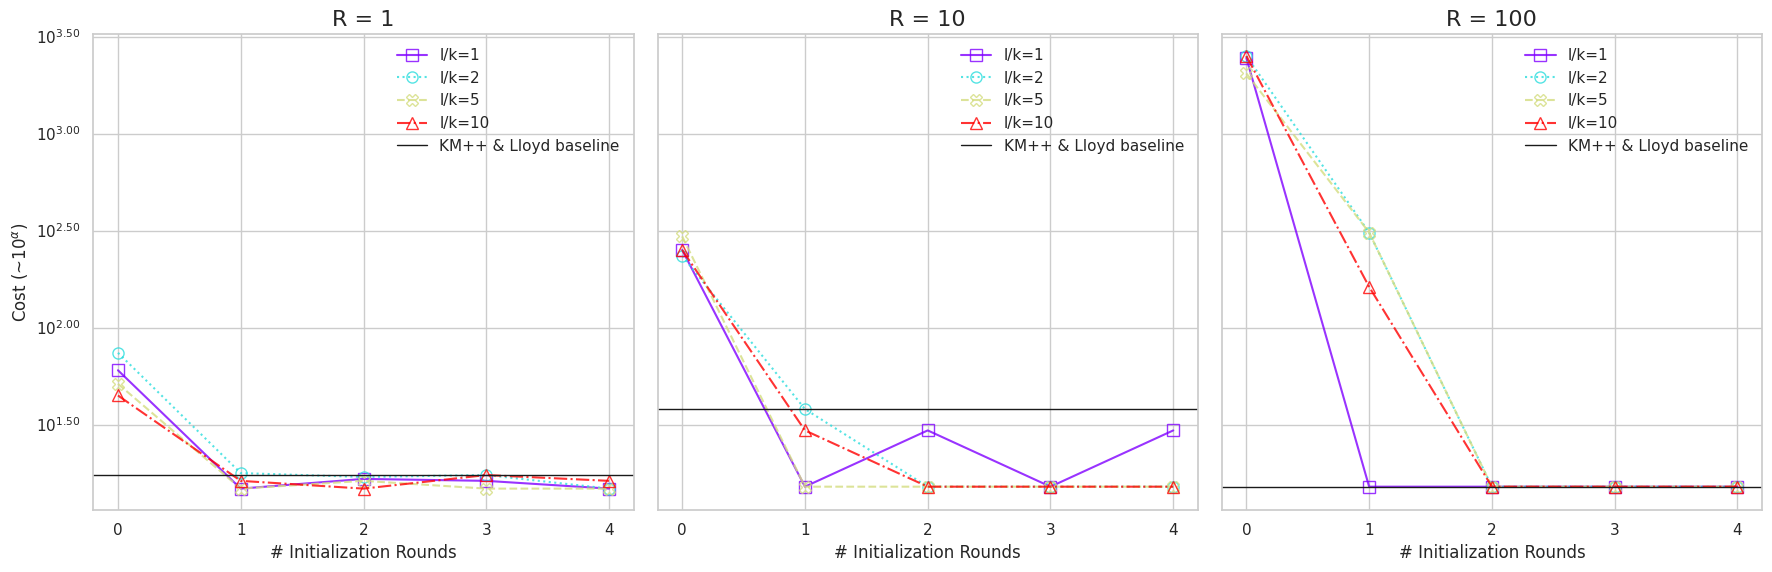

In [52]:
plot_results(results)

In [ ]:
"""# compute curves (KM|| seeds + Lloyd):
curves = run_curves(data_rdd, k, rounds, lk_ratio, iterations)

# baseline (KM++ seeds + Lloyd):
Cpp    = kMeansPlusPlus_init(data_narray, k)
CppFin = lloydKMeans(data_rdd, Cpp, epochs=iterations)
base   = exp10_cost(compute_cost(data_rdd, CppFin), 2)"""

In [ ]:
"""# ----- plot -----
fig, ax = plt.subplots(figsize=(7.2, 4.2))
for lk, phis in sorted(curves.items()):
    ax.plot(rounds, phis, marker='o', linewidth=1.5, label=f"l/k={lk}")

# if baseline:
ax.axhline(base, color='k', lw=1, label='KM++ & Lloyd')

ax.set_xlabel("# Initialization Rounds")
ax.set_ylabel("Cost (~$10^{\\alpha}$)")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: rf"$10^{{{y:.2f}}}$"))

lo = min(min(v) for v in curves.values())
hi = max(max(v) for v in curves.values())

#ax.set_ylim(lo-0.01, hi)
ax.set_title(f"R = {R}")
ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()"""

In [ ]:
"""# ----- controls -----
n          = 10_000
k          = 50
dim        = 15
R          = 1
rounds     = list(range(16))
lk_ratio   = [0.1, 0.5, 2, 5, 10]
iterations = 20

data_narray, true_centroids = gauss_mixture(n, k, dim, R)
data_rdd = sc.parallelize([row for row in data_narray])"""

In [ ]:
"""########### TEST ############
# C_psi = kMeansRandom_init(data_rdd, 1)
# psi  = cost_function(data_rdd, C_psi)
# C0   = kMeansParallel_init(data_rdd, k, l=int(lk_ratio[4]*k), r=int(rounds[15]))
# Cfin = naiveKMeans(data_rdd, C0, epochs=100_000)
# phi  = cost_function(data_rdd, Cfin) 
# psi, phi"""

In [ ]:
"""# compute curves (KM|| seeds + Lloyd):
curves = run_curves(data_rdd, k, rounds, lk_ratio, iterations)
# baseline (KM++ seeds + Lloyd):
Cpp    = kMeansPlusPlus_init(data_narray, k)
CppFin = lloydKMeans(data_rdd, Cpp, epochs=100_000)
base   = exp10_cost(compute_cost(data_rdd, CppFin), 2)"""

In [ ]:
"""# ----- plot -----
fig, ax = plt.subplots(figsize=(7.2, 4.2))
for lk, phis in sorted(curves.items()):
    ax.plot(rounds, phis, marker='o', linewidth=1.5, label=f"l/k={lk}")

# if baseline:
ax.axhline(base, color='k', lw=1, label='KM++ & Lloyd')

ax.set_xlabel("# Initialization Rounds")
ax.set_ylabel("Cost (~$10^{\\alpha}$)")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: rf"$10^{{{y:.2f}}}$"))

lo = min(min(v) for v in curves.values())
hi = max(max(v) for v in curves.values())

#ax.set_ylim(lo-0.01, hi)
ax.set_title(f"R = {R}")
ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()"""

In [ ]:
"""# ----- controls -----
n          = 10_000
k          = 50
dim        = 15
R          = 10
rounds     = list(range(16))
lk_ratio   = [0.1, 0.5, 2, 5, 10]
iterations = 20

data_narray10, true_centroids10 = gauss_mixture(n, k, dim, R)
data_rdd10 = sc.parallelize([row for row in data_narray10])"""

In [ ]:
"""# compute curves (KM|| seeds + Lloyd):
curves10 = run_curves(data_rdd10, k, rounds, lk_ratio, iterations)
# baseline (KM++ seeds + Lloyd):
Cpp10    = kMeansPlusPlus_init(data_narray10, k)
CppFin10 = lloydKMeans(data_rdd10, Cpp10, epochs=1_000)
base10   = exp10_cost(compute_cost(data_rdd10, CppFin10), 2)"""

In [ ]:
"""# ----- plot -----
fig, ax = plt.subplots(figsize=(7.2, 4.2))
for lk, phis in sorted(curves10.items()):
    ax.plot(rounds, phis, marker='o', linewidth=1.5, label=f"l/k={lk}")

# if baseline:
ax.axhline(base10, color='k', lw=1, label='KM++ & Lloyd')

ax.set_xlabel("# Initialization Rounds")
ax.set_ylabel("Cost (~$10^{\\alpha}$)")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: rf"$10^{{{y:.2f}}}$"))

lo = min(min(v) for v in curves10.values())
hi = max(max(v) for v in curves10.values())

#ax.set_ylim(lo-0.01, hi)
ax.set_title(f"R = {R}")
ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()"""

In [ ]:
"""# ----- controls -----
n          = 10_000
k          = 50
dim        = 15
R          = 100
rounds     = list(range(16))
lk_ratio   = [0.1, 0.5, 2, 5, 10]
iterations = 20

data_narray100, true_centroids100 = gauss_mixture(n, k, dim, R)
data_rdd100 = sc.parallelize([row for row in data_narray100])"""

In [ ]:
"""# compute curves (KM|| seeds + Lloyd):
curves100 = run_curves(data_rdd100, k, rounds, lk_ratio, iterations)
# baseline (KM++ seeds + Lloyd):
Cpp100    = kMeansPlusPlus_init(data_narray100, k)
CppFin100 = lloydKMeans(data_rdd100, Cpp100, epochs=1_000)
base100   = exp10_cost(cost_function(data_rdd100, CppFin100), 2)"""

In [ ]:
"""# ----- plot -----
fig, ax = plt.subplots(figsize=(7.2, 4.2))
for lk, phis in sorted(curves100.items()):
    ax.plot(rounds, phis, marker='o', linewidth=1.5, label=f"l/k={lk}")

# if baseline:
ax.axhline(base100, color='k', lw=1, label='KM++ & Lloyd')

ax.set_xlabel("# Initialization Rounds")
ax.set_ylabel("Cost (~$10^{\\alpha}$)")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: rf"$10^{{{y:.2f}}}$"))

lo = min(min(v) for v in curves.values())
hi = max(max(v) for v in curves.values())

#ax.set_ylim(lo-0.01, hi)
ax.set_title(f"R = {R}")
ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()"""

## KMeans further Analysis

In [ ]:
"""def analysis(
        data_array: npt.ArrayLike, 
        data_rdd: RDD, 
        r: int=0, 
        k: int=50, 
        lk_ratio: float=0.5,
        iterations: int=5, 
        batch_fraction: float=0.1,
        init_algo: str="random",
        up_algo: str="naive",
        ) -> npt.DTypeLike:
    
    results = []
    start = time.time()
    ######## Init ########
    if init_algo=="random": 
        centroids_init  = data_array[np.random.choice(data_array.shape[0], size=k, replace=False)]
        init_time = time.time() - start
        seed_cost = compute_cost(data_rdd, centroids_init)
    elif init_algo=="kmeans++": 
        centroids_init = kMeansPlusPlus_init(data_array, k)
        init_time = time.time() - start
        seed_cost = compute_cost(data_rdd, centroids_init)
    else: 
        init_time = []
        seed_cost = []
        for lk in lk_ratio:
            centroids_init = kMeansParallel_init(data_rdd, k=k, l=lk*k, r=r)
            init_time.append(time.time() - start)
            start = time.time()
            seed_cost.append(compute_cost(data_rdd, centroids_init))

    start = time.time()
    ######## Algo ########
    if up_algo=="naive": final_centroids = lloydKMeans(data_rdd, centroids_init, iterations)
    else: final_centroids = miniBatchKMeans(data_rdd, centroids_init, iterations, batch_fraction)
    final_time = time.time() - start
    final_cost = compute_cost(data_rdd, final_centroids)
    
    results.append({
        "method": init_algo,
        "algo": up_algo,
        "initialization_time (s)": f"{init_time:.3f}",
        "algo time (s)":f"{final_time:.3f}",
        "seed": f"{seed_cost/1e4:.3f}",
        "final": f"{final_cost/1e4:.3f}"
    })
    df = pd.DataFrame(results)
    return df"""

Paper analysis on Gaussian mixture

In [ ]:
"""R = [1, 10, 100]
res = []

n = 10_000
k = 50
dim = 15
r = 5
iterations = 100_000
batch_fraction = 0.3

for RR in R:
    data_array, true_centroids = gauss_mixture(n, k, dim, R=RR)
    data_rdd = sc.parallelize([row for row in data_array]).persist()
    for init_algo in ["random", "kmeans++", "kmeans||"]:
        df = analysis(
                data_array, 
                data_rdd, 
                r=r, 
                k=50, 
                lk_ratio=[0.5, 2],
                iterations=iterations, 
                batch_fraction=0.1,
                init_algo="random",
                up_algo="naive",
            )
        print(
            f"R={RR}\t", 
            f"algo={algo}", "\n","------------------------------", "\n"
        )

        res.append(df)
        data_rdd.unpersist()"""

# Lloyd Parallel vs. nPartitions

# Lloyd vs. Mini-Batch